# reconocimiento de formas

En esta lección estudiaremos el reconocimiento de objetos planos a partir de su silueta. Inicialmente estamos interesados en figuras rígidas observadas con poca inclinación.

## bibliotecas y funciones

In [1]:
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt
from matplotlib.pyplot   import imshow, subplot, title, plot
%matplotlib inline

from skimage             import data
from scipy               import ndimage

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    imshow(x, 'gray')

## imágenes de test

Al final de la clase debemos ser capaces de reconocer formas como las siguientes.

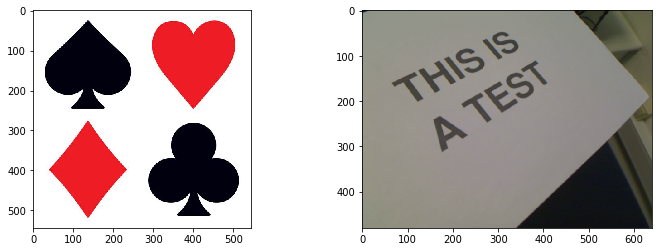

In [2]:
fig(12,4)
subplot('121')
imshow(readrgb('shapes/card-suits.jpg'));
subplot('122')
imshow(readrgb('contours.png'));

El problema puede descomponerse en varios pasos: umbralización, extracción de contornos, extracción de características invariantes y clasificación.

## umbralizado

(303, 384)


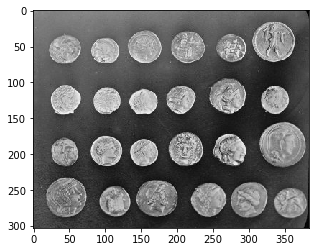

In [3]:
g = data.coins()
print(g.shape)
imshowg(g)

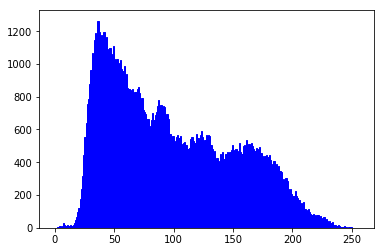

In [4]:
plt.hist(g.flatten(), bins=np.arange(257), fc='b', ec='b');

OpenCV proporciona [varios métodos](http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html).

Umbral **manual**.

75.0


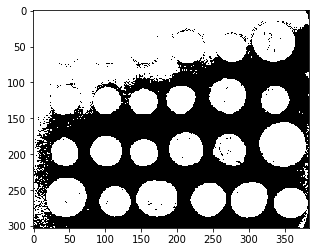

In [5]:
ret, gt = cv.threshold(g,75,255,cv.THRESH_BINARY)

print(ret)

imshowg(gt);

In [6]:
# >jupyter nbextension enable --sys-prefix --py widgetsnbextension

from ipywidgets import interactive, FloatSlider

def fun(h):
    imshowg(g>h);

#interactive(fun, h=(0,255))
interactive(fun, h=FloatSlider(min=0, max=255,step=1, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='h', max=255.0, step=1.0), Output()), _dom_classes=('widget-interact',))

Umbral **automático** (global para todo el ROI): [método de Otsu](https://en.wikipedia.org/wiki/Otsu%27s_method).

107.0


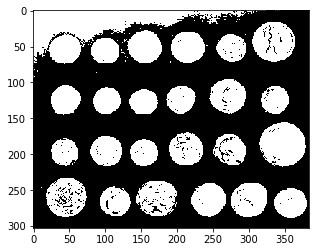

In [7]:
ret, gt = cv.threshold(g,189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
#ret, gt = cv.threshold(g[0:150,0:150],189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

print(ret)

imshowg(gt);

Umbral **adaptativo**:

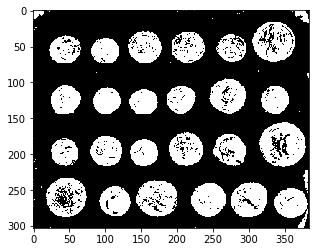

In [8]:
gt = cv.adaptiveThreshold(g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,101,-10)

imshowg(gt);

## extracción de contornos

69
[[[381 248]]

 [[380 249]]

 [[381 249]]

 [[382 248]]]
(4, 1, 2)


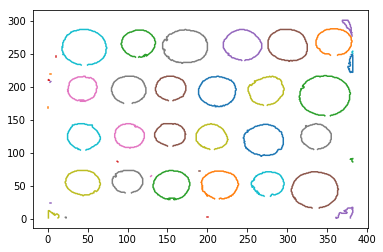

In [9]:
a,contours,b = cv.findContours(gt.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
                                          #cv.RETR_CCOMP  , cv.CHAIN_APPROX_NONE
                                          #devuelve todos
    
# a es la imagen resultante (!?)
# b da información de qué contornos están dentro de otros 
# contours tiene estructura nx1x2 (!?)

print(len(contours))
print(contours[10])
print(contours[10].shape)


for x in contours:
    plot(x[:,:,0],x[:,:,1])

Seleccionamos los que no son muy cortos y redimensionamos su estructura a $n\times 2$.

24


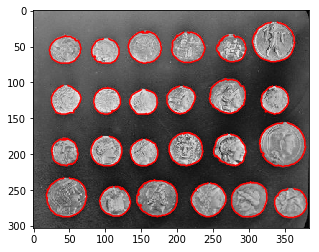

In [10]:
ok = [ x.reshape(-1,2) for x in contours if len(x)> 50 ]

print(len(ok))

imshowg(g);
for c in ok:
    x,y = c.T
    plot(x,y,'red')

OpenCV proporciona varias funciones para [manipular contornos](http://docs.opencv.org/3.2.0/dd/d49/tutorial_py_contour_features.html).

## separación de componentes conexas

Un método alternativo para segmentar zonas destacadas en una imagen es obtener las componentes conexas. Se expresan como una imagen de etiquetas.

106
int32


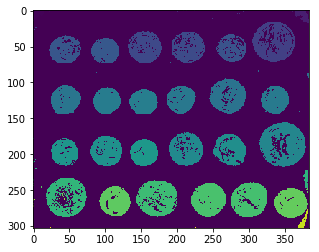

In [11]:
n,cc = cv.connectedComponents(gt.copy())
print(n)
imshow(cc);
print(cc.dtype)

(Hay que hacer copia del argumento porque de nuevo la implementación de opencv de esta función destruye la imagen de entrada.)

Intentamos eliminar las regiones muy pequeñas con operaciones morfológicas.

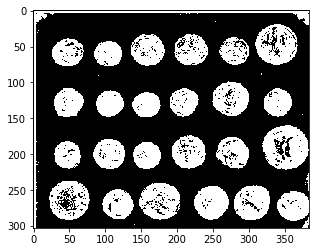

In [12]:
opening = cv.morphologyEx(gt, cv.MORPH_OPEN, np.zeros([5,5],np.uint8), anchor=(-1,-1))

imshowg(opening)

La implementación de *opening* en `scipy.ndimage` funciona bastante bien:

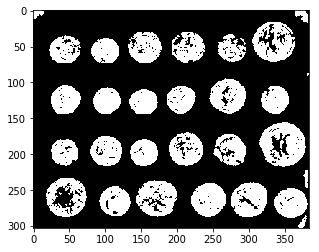

In [13]:
opening = ndimage.morphology.binary_opening(gt)

imshowg(opening)

También podemos rellenar los agujeros:

bool


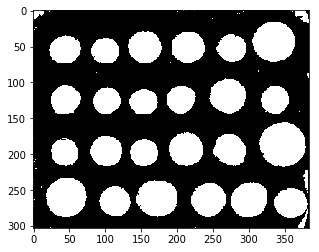

In [14]:
gtf = ndimage.binary_fill_holes(gt)
print(gtf.dtype)
imshowg(gtf);

O combinar ambas operaciones para conseguir una buena colección de regiones candidatas:

bool


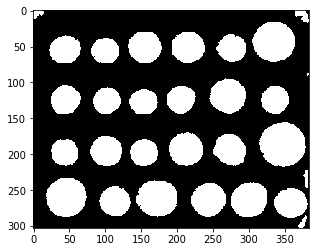

In [15]:
gtf = ndimage.morphology.binary_opening(ndimage.binary_fill_holes(gt))
print(gtf.dtype)
imshowg(gtf);

30


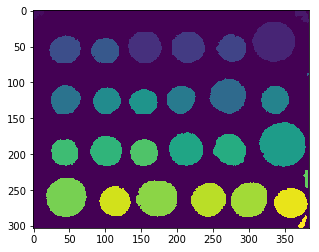

In [16]:
n,cc = cv.connectedComponents(gtf.astype(np.uint8).copy())
print(n)
imshow(cc);

Podemos crear una máscara booleana para una región concreta:

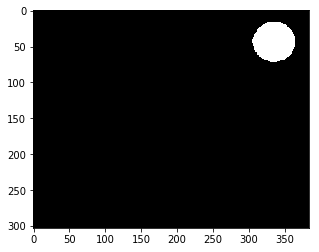

In [17]:
imshowg(cc==3)

Creamos una listas de máscaras booleanas para las regiones suficientemente grandes:

In [18]:
ok = [ cc==k for k in range(1,n) if np.sum(cc==k) > 300]
len(ok)

24

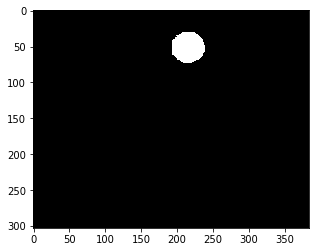

In [19]:
imshowg(ok[2])

Ahora podemos extraer cualquier región de la imagen original:

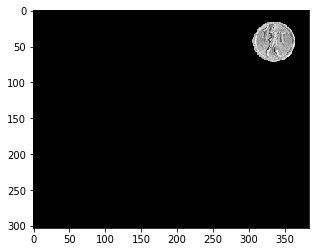

In [20]:
res = np.zeros(g.shape)
np.copyto(res, g, where = ok[0])
imshowg(res);

Otra forma:

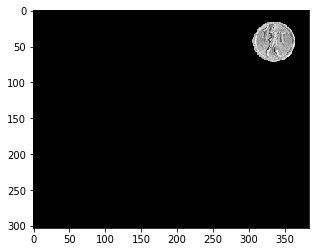

In [21]:
res = np.zeros_like(g)
res[ok[0]] = g[ok[0]]
imshowg(res)

Se puede hacer lo mismo borrando donde no esté la figura:

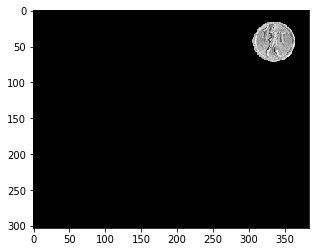

In [22]:
res = g.copy()
res[ok[0]==False] = 0
imshowg(res)

Si queremos podemos recortar las regiones:

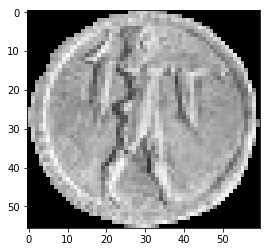

In [23]:
thing = np.argwhere(ok[0])
(x1, y1), (x2, y2) = thing.min(0), thing.max(0)

box = res[x1:x2+1,y1:y2+1]
imshowg(box)

Todo junto:

In [24]:
#view = readrgb("plate.jpg")
view = readrgb("contours.png")
print(view.shape)

ret, gt = cv.threshold(cv.cvtColor(view,cv.COLOR_RGB2GRAY),100,255,cv.THRESH_BINARY_INV)
n,cc = cv.connectedComponents(gt.copy())
print(n)
ok = [ cc==k for k in range(1,n) ]

def sacalo(mask):
    thing = np.argwhere(mask)
    (x1, y1), (x2, y2) = thing.min(0), thing.max(0)
    box = mask[x1:x2+1,y1:y2+1].astype(np.float32)
    return box

promising = [sacalo(ok[k]) for k in range(1,len(ok))]
promising = [ p for p in promising if p.sum() > 100]
print(len(promising))

(480, 640, 3)
17
14


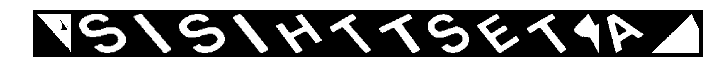

In [25]:
def normalize_size(x):
    h,w = x.shape[:2]
    r = cv.resize(x, (0,0), fx=100/h, fy = 100/h)
    return np.pad(r,10,mode='constant',constant_values=0)

fig(12,8)
imshowg(np.hstack([normalize_size(x) for x in promising]))
plt.axis('off');

## MSER

*[Maximally Stable Extremal Regions](https://en.wikipedia.org/wiki/Maximally_stable_extremal_regions)*: otro método para encontrar regiones destacadas. Se basa en encontrar los umbrales de binarización cuyo cambio produce el menor cambio de área.

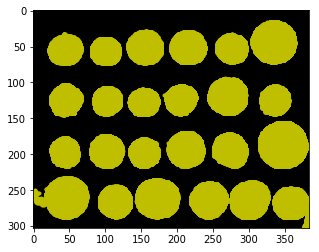

In [26]:
mser = cv.MSER_create()
regs = mser.detectRegions(g, bboxes=None)

# devuelve "conjuntos" de puntos, nx2, 
# (no contornos (silueta), ni imagen de etiquetas)
# El segundo resultado es una lista de rectángulos (bounding boxes)

# dibujar con plot todos los puntos es lento
imshowg(g*0);
for x in regs:
    plot(x[:,0],x[:,1],'.y')

Es más rápido rellenar una imagen vacía con los puntos obtenidos.

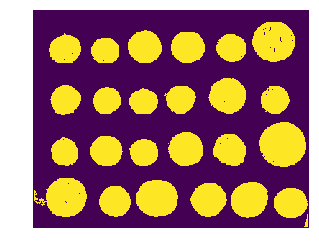

In [27]:
res = np.zeros_like(g)
for p in regs:
    x,y = p.T
    res[y,x] = 255
imshow(res); plt.axis('off');

Esto nos permite obtener los contornos con `findContours`:

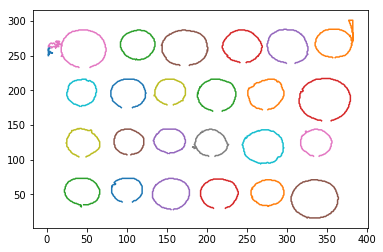

In [28]:
_,conts,_ = cv.findContours(res,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

for x in conts:
    plot(x[:,:,0],x[:,:,1])

Asignando el mismo valor a todos perdemos los posibles contornos internos. Otra posibilidad es:

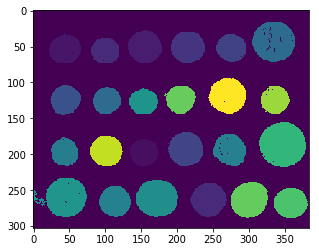

In [29]:
res = np.zeros_like(g)
for k, p in enumerate(regs):
    x,y = p.T
    res[y,x] = k+1

imshow(res);

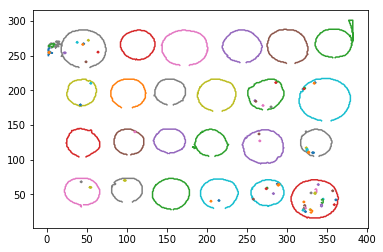

In [30]:
_,conts,_ = cv.findContours(res,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)

for x in conts:
    plot(x[:,:,0],x[:,:,1])
#plt.axis(ax);

(Es posible también extraer las regiones MSER en forma de *keypoint* con `mser.detect`.)

## funciones útiles

Una vez vistos diferentes métodos de segmentación de regiones, vamos a definir funciones para extraer y representar contornos de forma cómoda.

Los descriptores que definiremos más adelante necesitan que los contornos que deseamos reconocer y los modelos se recorran en el mismo sentido.

In [31]:
def orientation(x):
    return cv.contourArea(x.astype(np.float32),oriented=True) >= 0

def fixOrientation(x):
    if orientation(x):
        return x
    else:
        return np.flipud(x)

In [32]:
def extractContours(g, minlen=50, holes=False):
    if holes:
        mode = cv.RETR_CCOMP
    else:
        mode = cv.RETR_EXTERNAL
    gt = cv.adaptiveThreshold(g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,101,-10)
    a,contours,b = cv.findContours(gt.copy(), mode ,cv.CHAIN_APPROX_NONE)
    ok = [fixOrientation(c.reshape(len(c),2)) for c in contours if cv.arcLength(c,closed=True) >= minlen]
    return ok

def shcont(c, col='b', nodes=False, flipy = False):
    x = c[:,0]
    y = c[:,1]
    if flipy: y = - y
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plot(x,y,col)
    if nodes: plot(x,y,col+'.',markerSize=10)

## reducción de nodos

En algunas aplicaciones puede interesar una representación compacta de los contornos reduciendo los vértices "redundantes".

(15, 2)


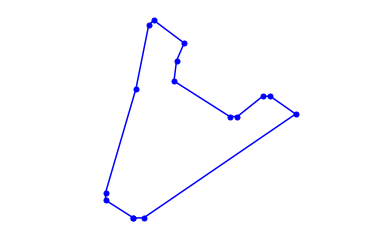

In [33]:
g = 255 - rgb2gray(readrgb('contours.png'))

conts = extractContours(g)

red = cv.approxPolyDP(conts[2],0.9,True)
red = red.reshape(red.shape[0],2)

print(red.shape)

shcont(red,nodes=True)
plt.axis('equal'); plt.axis('off');

In [34]:
def fun2(m=2,eps=1.0):
    r = cv.approxPolyDP(conts[m],eps,True)
    r = r.reshape(r.shape[0],2)
    shcont(r,nodes=True)
    shcont(conts[m],'g')
    plt.axis('equal'); plt.axis('off');
    

interactive(fun2, m=(0,len(conts)-1), eps=(0.0,5.0))   

interactive(children=(IntSlider(value=2, description='m', max=15), FloatSlider(value=1.0, description='eps', max=5.0), Output()), _dom_classes=('widget-interact',))

En ciertos casos es posible detectar cierto tipo de figuras (p.ej. cuadriláteros) si el número de nodos de la versión reducida con una tolerancia adecuada es el correcto, pero como los vértices suelen suavizarse en la imagen los vértices resultantes no son muy precisos.

## clasificación de siluetas

Finalmente llegamos a nuestro principal objetivo: reconocer formas mediante descriptores invariantes. En primer lugar vamos capturar unos cuantos modelos.

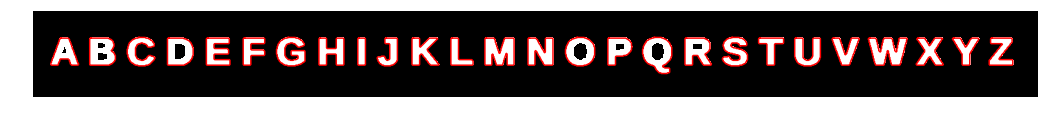

In [35]:
g = 255-rgb2gray(readrgb('shapes/AZ.png'))

g = ndimage.morphology.binary_dilation(g).astype(np.uint8)*255

fig(18,4)
imshowg(g); ax = plt.axis('off');
for x in extractContours(g):
    shcont(x,'r')
plt.axis(ax);

(Los hemos engordado un poco con una operación morfológica de dilatación para que se parezcan un poco más a las letras que usaremos después.)

Hay que tener cuidado porque pueden llegar desordenados. Vamos a ordenarlos de izquierda a derecha (de acuerdo con la coordenada x del primer punto), para poder asociar etiquetas a cada modelo.

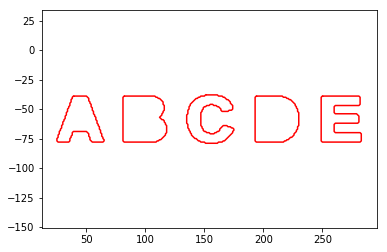

In [36]:
models = sorted(extractContours(g), key=lambda x: x[0,0])
labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for x in models[0:5]:
    plot(x[:,0],-x[:,1],'r')
plt.axis('equal');

Vamos a utilizar descriptores de forma frecuenciales. Es interesante mostrar un suavizado frecuencial de las siluetas, para hacernos una idea de cuántas frecuencias necesita el descriptor para distinguir aceptablemente los modelos de nuestro problema.

In [37]:
import numpy.fft as fft

def smooth(w,c):
    z = c[:,0]+c[:,1]*1j # convertimos 2D a 1D complejo
    f  = fft.fft(z)      # calculamos la descomposición frecuencial      
    f[w+1:-w] = 0        # quitamos las frecuencias mayores a w 
    ccs = fft.ifft(f)    # reconstruimos la señal
    return np.vstack([np.real(ccs),np.imag(ccs)]).transpose() # pasamos los números complejos a pares x,y


def fun(m=4,w=5):
    s = smooth(w,models[m])
    plot(s[:,0],-s[:,1]); plt.axis('equal');

interactive(fun, m=(0,len(models)-1), w=(0,40))    

interactive(children=(IntSlider(value=4, description='m', max=25), IntSlider(value=5, description='w', max=40), Output()), _dom_classes=('widget-interact',))

No parece necesario conservar frecuencias mucho más altas que 10.

El invariante frecuencial de un contorno puede definirse así:

In [38]:
def invar(c, wmax=10):
    z = c[:,0]+c[:,1]*1j
    f  = fft.fft(z)
    fa = abs(f)                     # para conseguir invarianza a rotación 
                                    # y punto de partida
    s = fa[1] + fa[-1]              # el tamaño global de la figura para normalizar la escala
    fp = fa[2:wmax+2];              # cogemos las componentes de baja frecuencia, positivas
    fn = np.flipud(fa)[1:wmax+1];   # y negativas
    return np.hstack([fp, fn]) / s

Deberíamos comprobar que descriptor es realmente invariante a posición, tamaño, orientación, punto de partida en el muestreo y ruido. (Y diferente en los distintos modelos.)

In [39]:
invar(models[0],3)

array([ 0.16524975,  0.06212112,  0.10147801,  0.25118374,  0.06402732,
        0.01475016])

In [40]:
invar(3*np.roll(models[0],37,0)+np.array([[100,200]]),3)

array([ 0.16524975,  0.06212112,  0.10147801,  0.25118374,  0.06402732,
        0.01475016])

Ojo: si el contorno se recorre en sentido contrario el descriptor cambia, aunque la figura sea la misma:

In [41]:
invar(np.flipud(models[0]),3)

array([ 0.25118374,  0.06402732,  0.01475016,  0.16524975,  0.06212112,
        0.10147801])

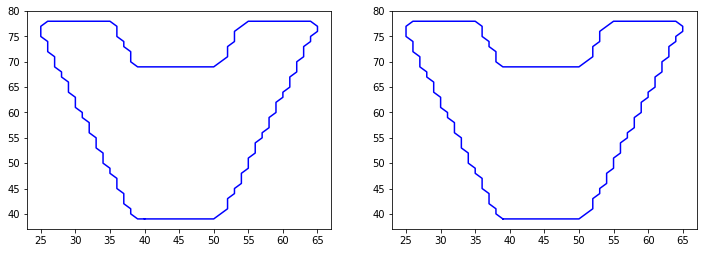

In [42]:
fig(12,4)
subplot(1,2,1); shcont(models[0])
subplot(1,2,2); shcont(np.flipud(models[0]))

Por eso es necesario aplicar `fixOrientation` en la función `extractContours` que definimos antes.

Ahora capturamos los contornos de la escena que nos interesa reconocer.

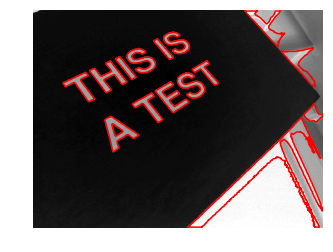

In [43]:
img = readrgb('contours.png')
#img = readrgb('letras.png')[50:260,80:520]

g = 255-rgb2gray(img)
things = extractContours(g,holes=True)

imshowg(g); ax = plt.axis('off');
for x in things:
    shcont(x,'r')
plt.axis(ax);

Para facilitar la clasificación construimos una función que compara un vector con un conjunto de modelos y devuelve ordenadas las distancias y la correspondiente etiqueta.

In [44]:
def mindist(c,mods,labs):
    import numpy.linalg as la
    ds = [(la.norm(c-mods[m]),labs[m]) for m in range(len(mods)) ]
    return sorted(ds, key=lambda x: x[0])

La probamos con uno de los contornos:

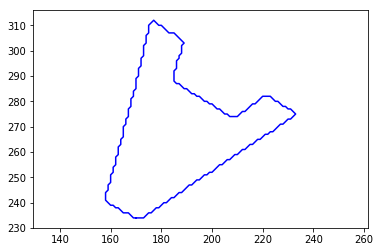

In [45]:
x = things[2]
shcont(x); plt.axis('equal');

In [46]:
feats = [invar(m) for m in models]

mindist(invar(x),feats,labels)[0:5]

[(0.052646355079834749, 'A'),
 (0.087390410547447409, 'Y'),
 (0.148646492806465, 'L'),
 (0.17149895479997967, 'T'),
 (0.18123211697029334, 'P')]

Y ya con toda la imagen, mostrando solo las manchas que se clasifican aceptablemente bien:

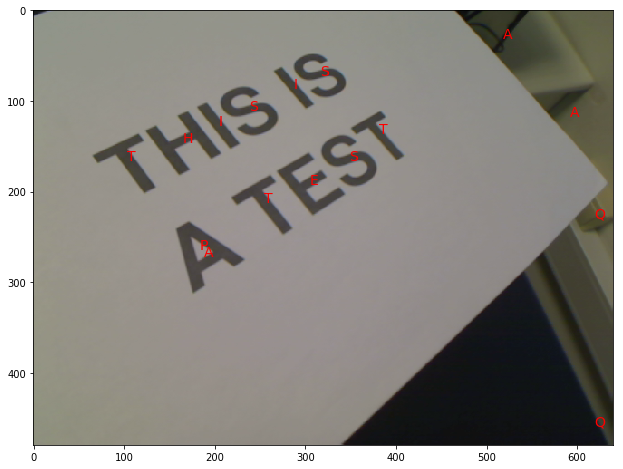

In [47]:
fig(12,8)
imshow(img)
for x in things:
    d,l = mindist(invar(x),feats,labels)[0]
    if d < 0.15:
        cx,cy = np.mean(x,0)
        plt.text(cx,cy,l,color='red',fontsize=14)

Hay que tener en cuenta que se trata de una vista en perspectiva, más compleja que un cambio de tamaño y rotación. Por tanto, hay que aumentar la tolerancia en la distancia entre descriptores, lo que produce "falsos positivos". Si queremos evitarlos perderíamos detecciones correctas.

Algunos falsos positivos se podrían evitar eliminando de antemano contornos muy grandes o muy pequeños, o que tocan con los límites de la imagen.

Veamos otros ejemplos:

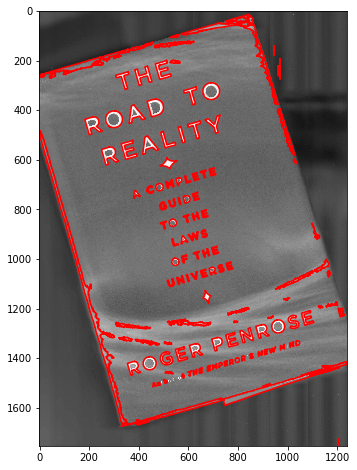

In [48]:
#img = readrgb('letras.png')[50:260,80:520];  g = rgb2gray(img)
#img = readrgb('goldstein.jpg'); g = 255 - rgb2gray(img)
img = cv.resize(readrgb('penrose.jpg'),(0,0),fx=0.5,fy=0.5); g = rgb2gray(img)

things = extractContours(g,holes=False,minlen=50)

fig(12,8)
imshowg(g); ax = plt.axis();
for x in things:
    shcont(x,'r')
plt.axis(ax);

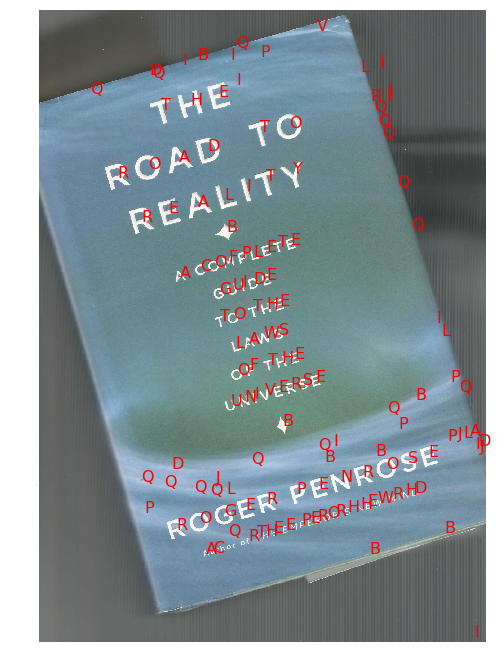

In [49]:
fig(8,12)
imshow(img); plt.axis('off');
for x in things:
    d,l = mindist(invar(x),feats,labels)[0]
    if d < 0.2:
        cx,cy = np.mean(x,0)
        plt.text(cx,cy,l,color='red',fontsize=16)

Pueden producirse fallos causados por un tipo de letra distinto al de los modelos, por deformaciones de perspectiva y por fallos de detección, al quedarse letras pegadas.

La invarianza a inclinación moderada (en condiciones de perspectiva débil, que estudiaremos en una clase posterior) se consigue mediante la transformación de *whitening*.